janomeについて

https://note.nkmk.me/python-janome-tutorial/

globについて

https://techacademy.jp/magazine/18928

In [1]:
from janome.tokenizer import Tokenizer
import re
import glob##パス名を取得

In [28]:
##ほんとは　序章部分も回すべき
no_zero = glob.glob("アルマーク/序章/*") 
no_zero

['アルマーク/序章/N9407FU-5.txt',
 'アルマーク/序章/N9407FU-4.txt',
 'アルマーク/序章/N9407FU-3.txt',
 'アルマーク/序章/N9407FU-2.txt',
 'アルマーク/序章/N9407FU-1.txt']

In [8]:
## transer用
no_zero =  ["Transer/N7235FU-8.txt"]

In [29]:
lines = open(no_zero[4],"r",encoding="utf-8")

#\n を削除した文章化(\u3000 は全角空白？) はしない
lines = lines.read()##re.sub(r"[akira]","",text.read())
        
t = Tokenizer()
##streams = [print(token) for token in t.tokenize(lines)]

In [92]:
import collections
from janome.tokenizer import Tokenizer

def parse_voc(text):
    t = Tokenizer()
    
    ##助動詞 or 助詞 + 別の品詞 + 、。 が来るまで合体させる
    vocs = []
    voc = ""##vocを合体させる部分
    before_voc = ""##前回のvoc字ズラのまま
    before_nomal_voc = ""##前回のvoc言い切り型
    before_word_type = ""
    remove = ["助動詞","助詞"]
    ##split_norm = ["数","代名詞"]##名刺でも取り除く(分解する分類)
    
    #\u3000は全角空白
    ##ここで分割する文字達(一部 file_read部分で置き換え)
    split_char = ["、","。"," ","　","する","ある","いる","なる","この","これ","その","それ","そこ","そう","れる"]
    
    ## 2番目の削除タイプ判定
    second_remove = ["空白","非自立"]## ~のようだ の ようを消す

    for token in t.tokenize(text):#[”。”]は無理矢理処理数を増やすため
        ##print(token)
        now_word_type, now_word_type2 = token.part_of_speech.split(",")[0:2]
        
        ##助詞・助動詞の処理 + 、。の処理 + 改行や空白(\u3000)の時の処理
        if now_word_type in remove or token.base_form in split_char or now_word_type2 in second_remove:
            voc += before_nomal_voc##動詞を切りのいい形で代入
            if voc:##空語(助詞・助動詞で生まれる)を取り除く
                vocs.append(voc)
            voc = ''
            before_word_type = ""
            before_nomal_voc = ""
        
        ##前回と同じ品詞 = 分割ミス として一つ前の変換値を繋げる + 名詞-数字の連鎖を断つための処理(この時、前が接頭辞かを確認すべき)
        elif (before_word_type == "接頭詞" and now_word_type2 == "数") or before_word_type == now_word_type:
            voc += before_voc
            ##初期化
            before_voc = token.surface ##今の単語の字ズラままを入れる
            before_nomal_voc = token.base_form ##今の単語を読み切りの形に
            before_word_type = now_word_type##品詞変更
        else:
            voc += before_nomal_voc
            ##空語(助詞・助動詞で生まれる)を取り除く 
            if voc:
                vocs.append(voc)##前回までの単語を追加
                voc=""
            
            ##初期化
            before_voc = token.surface ##今の単語の字ズラままを入れる
            before_nomal_voc = token.base_form ##今の単語を読み切りの形に
            before_word_type = now_word_type##品詞変更
            
    ##集めた単語を返す
    return vocs

#c = collections.Counter(vocs)
#c

## 正規表現
https://uxmilk.jp/41416

http://www-creators.com/archives/2612

In [93]:
##ファイルの読み込み
import re
import glob

## 空白に変更する記号 間違えてくっつかせないため(半角のカッコはエスケープする必要あり)
subtract_mark = r"'|[|]|「|」|『|』|《|》|【|】|（|）|｛|｝|\(|\)"

def concat_voc(dir_name):
    file_names = glob.glob(dir_name+"/*")
    voc_list = []
    
    ##print(file_names)
    for file_name in file_names:
        with open(file_name,"r",encoding="utf-8") as f:
            file = f.read().replace("&quot;",' ')## "(&quot;) を半角空白に変更(戻す)
            file = re.sub(subtract_mark," ",file)
            ##あとがき部分を見つける
            end = file.find("************************************************")
            ##前書き部分を見つける
            start = file.find("********************************************")
            
            ##前書きがない場合
            if start == end:
                start = 0
            ##あとがきがない場合
            if end == -1:
                end = len(file)-1
            
            ##あとがき, 前書きの削除
            file = file[start:end]
            
            ##題名以降の部分を見つける
            main_start = file.find("\n")
            plus_start = 0
            if start:
                ##前書きがある場合は ******部分が残るため その後の 題名を消すには二回行う
                plus_start = file[main_start:].find("\n")
            ##print(file[main_start+plus_start:])
            voc_list += parse_voc(file[main_start + plus_start:])
        
    return voc_list

### WordCloud
https://qiita.com/Senple/items/1ad08b1a7ac9560bef62

### フォントダウンロード(今回は はんなり明朝)
https://jp.stanby.com/media/free-font/

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fpath = "hannari/Hannari.otf"##日本語文字化けを防ぐ(ダウンロードしたもの)

##フォルダ(章)ごとのlistを生成
def make_cloud_and_lists(chapter_folders):
    voc_lists= []
    for chapter_folder_name in chapter_folders:
        voc_list = concat_voc(chapter_folder_name)
        voc_lists.append(voc_list)
        c = collections.Counter(voc_list)
    
        words = ""
        for word in voc_list:
            words = words + " " + word
        
    
        wordcloud =  WordCloud(background_color="white",
                               font_path=fpath,
                               width=800,
                               height=500).generate(words)
        ##WordCloudの表示
        print(chapter_folder_name)
        plt.figure(figsize=(30,24))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    
        print(c)
        print("\n\n")
    
    return voc_lists

アルマーク/序章


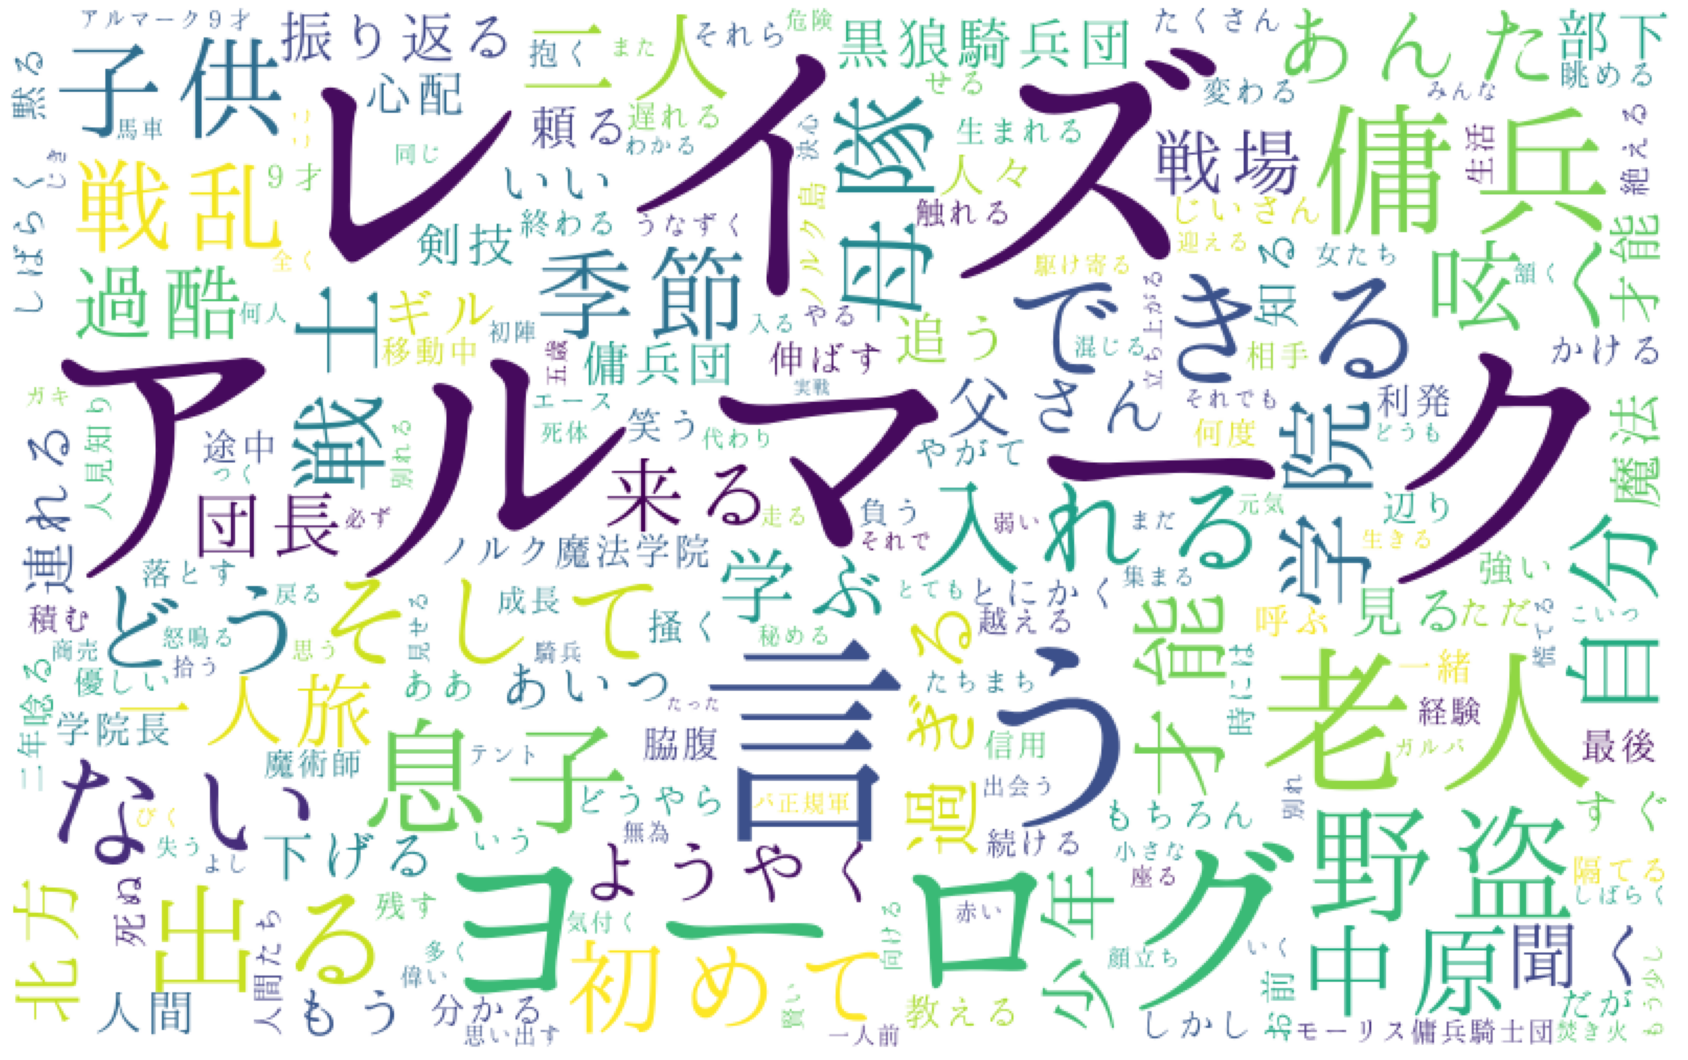

Counter({'アルマーク': 53, 'レイズ': 53, '言う': 28, 'ヨーログ': 23, '彼': 21, '老人': 13, '旅': 11, '傭兵': 10, '北': 9, 'できる': 9, 'ない': 9, '才能': 9, '息子': 8, '父': 8, '……': 8, '野盗': 8, '出る': 7, '頭': 7, '子供': 6, '冬': 6, '入れる': 6, 'そして': 6, 'どう': 6, '母隊': 6, '俺': 6, '顔': 6, '季節': 5, 'さ': 5, '戦士': 5, '中原': 5, '春': 5, '戦乱': 5, '初めて': 5, '二人': 5, '自分': 5, '何': 5, 'しばらく': 5, '手': 5, '呟く': 5, '学院': 5, 'あんた': 5, '一人旅': 4, '過酷': 4, '過ぎる': 4, '学ぶ': 4, '少年': 4, '姿': 4, '来る': 4, 'ようやく': 4, '剣': 4, '聞く': 4, '団長': 4, '戦場': 4, '北方': 4, '父さん': 4, '黒狼騎兵団': 4, '黙る': 4, '声': 4, 'いい': 4, '子': 4, 'もう': 4, '振り返る': 4, '見る': 4, '魔法': 4, '連れる': 4, '下げる': 4, 'あいつ': 4, '部下': 4, '追う': 4, '傭兵団': 3, '心': 3, '敵': 3, '命': 3, '剣技': 3, '頼る': 3, '人間': 3, '人々': 3, '心配': 3, '知る': 3, '夏': 3, '南': 3, 'すぐ': 3, 'ノルク魔法学院': 3, '教える': 3, '目': 3, '話': 3, '唸る': 3, 'どうやら': 3, '呼ぶ': 3, 'しかし': 3, '戦': 3, '一緒': 3, '強い': 3, 'お前': 3, '最後': 3, 'やがて': 3, '分かる': 3, '利発': 3, '私': 3, 'もちろん': 3, 'ただ': 3, '死ぬ': 3, '名': 3, '口': 3, 'ああ': 3, 'かける': 3, 'だが': 3, '足': 3

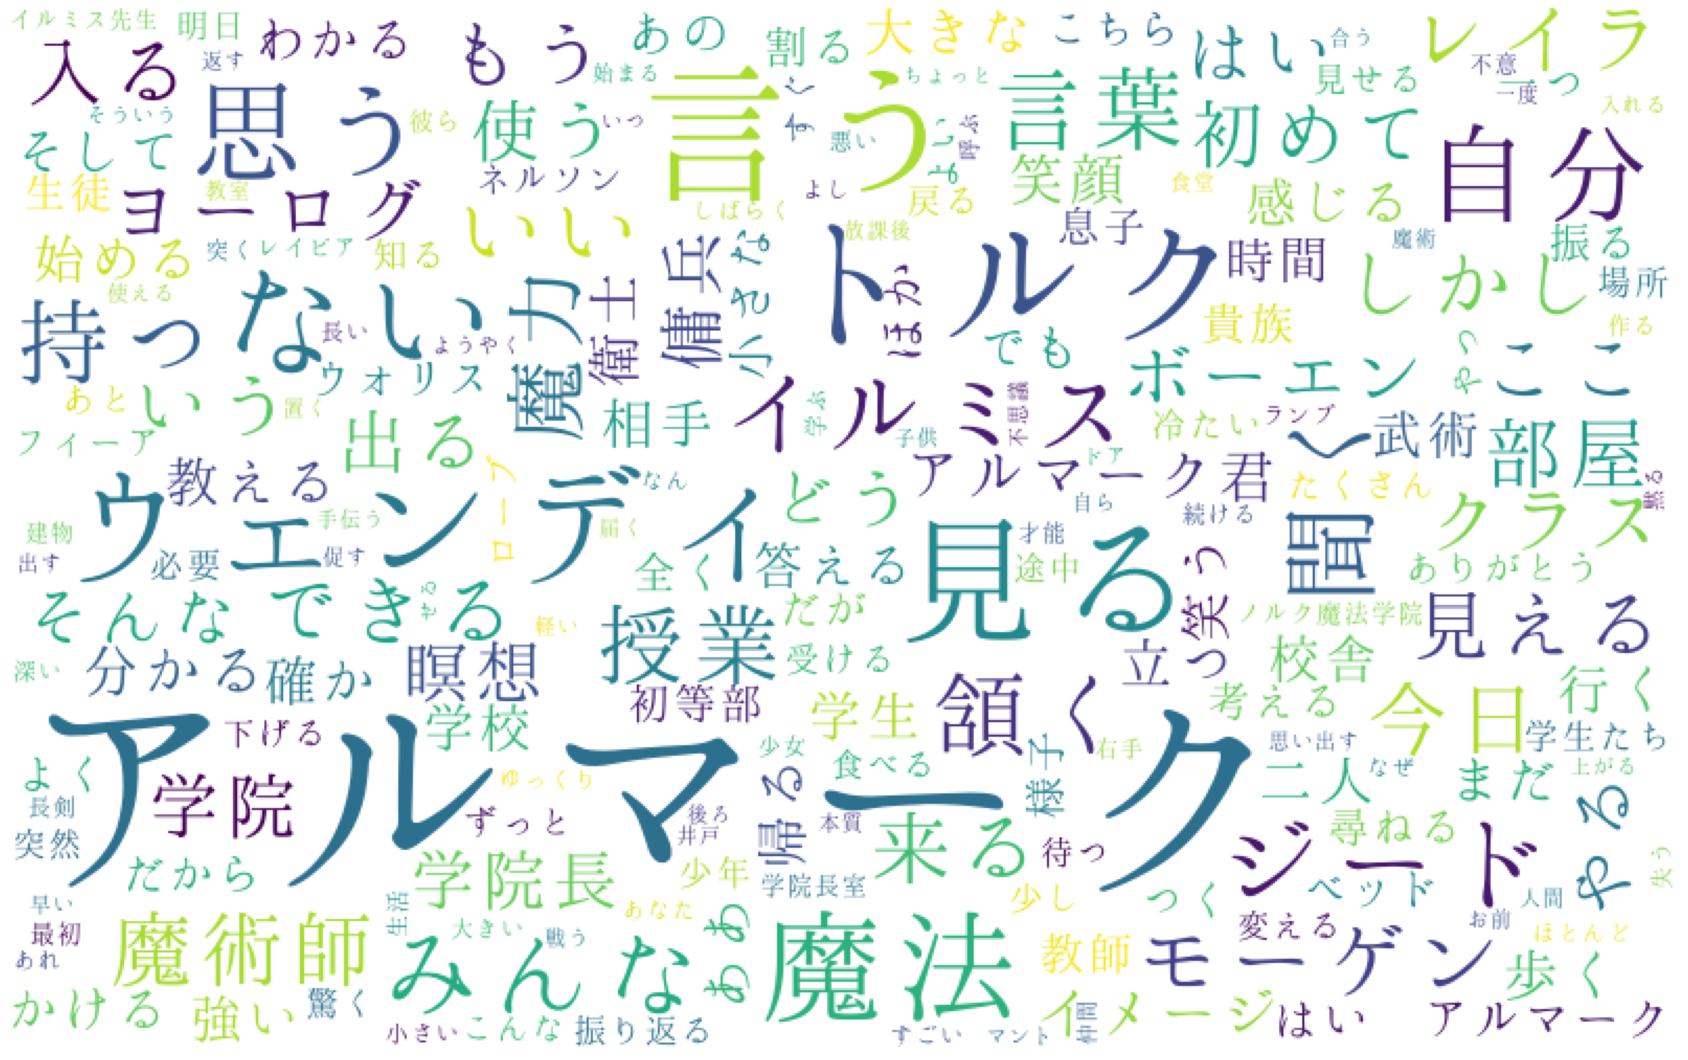

Counter({'アルマーク': 333, '……': 125, '言う': 96, 'トルク': 83, '見る': 81, 'ウェンディ': 74, '君': 71, 'ない': 70, '魔法': 59, '目': 55, '？': 52, '思う': 49, '自分': 45, '彼': 45, 'ジード': 40, '顔': 38, 'みんな': 38, '聞く': 37, '何': 37, '僕': 37, 'イルミス': 34, '頷く': 33, '持つ': 33, '北': 33, '体': 32, '炎': 32, '言葉': 31, 'はい': 31, '声': 31, '授業': 28, 'いい': 28, 'モーゲン': 27, '今': 27, '父': 27, '魔力': 26, '今日': 25, '！': 25, '魔術師': 25, '来る': 24, '剣': 24, 'しかし': 24, 'ここ': 24, 'できる': 24, '杖': 24, '石': 24, '前': 23, '入る': 23, '部屋': 23, '見える': 23, 'レイラ': 22, 'いう': 21, '初めて': 21, 'クラス': 21, 'もう': 21, '灯': 21, 'ヨーログ': 21, '子': 20, '学院': 19, 'ボーエン': 19, '手': 19, '出る': 19, '使う': 18, 'どう': 18, '貴族': 18, 'やる': 18, '寮': 18, '私': 18, '傭兵': 17, '力': 17, 'そんな': 17, '瞑想': 17, '学院長': 16, '笑う': 16, 'アルマーク君': 16, '分かる': 16, 'イメージ': 16, 'ああ': 15, '頭': 15, '誰': 15, '二人': 15, '笑顔': 15, '立つ': 15, '人': 15, 'さ': 15, '旅': 15, '衛士': 15, '歩く': 15, '確か': 14, '相手': 14, '教師': 14, 'ウォリス': 14, '教える': 14, '帰る': 14, '大きな': 14, '学生': 14, '話': 14, '…': 14, '外': 14, '行く'

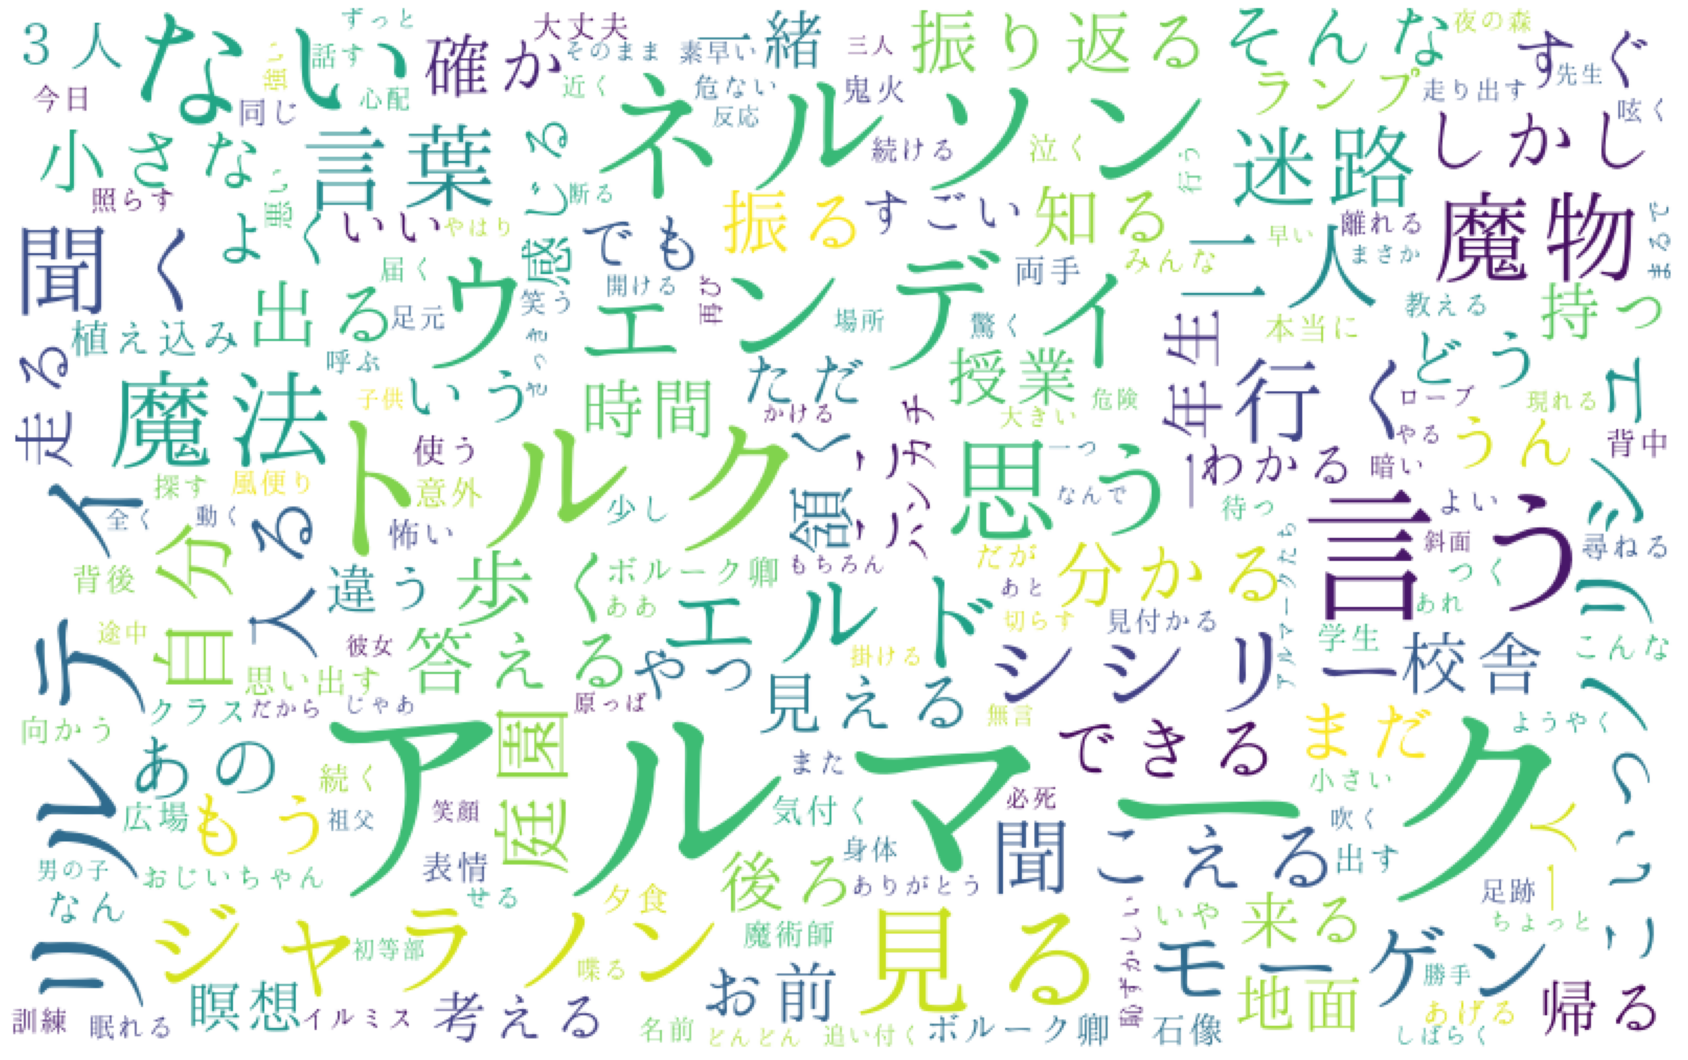

Counter({'アルマーク': 280, '……': 108, 'トルク': 98, '言う': 79, 'ネルソン': 79, 'ない': 74, '声': 71, '？': 71, 'ウェンディ': 68, 'リルティ': 68, '森': 60, '見る': 53, '！': 52, '魔法': 47, '思う': 46, 'エルド': 41, 'ジャラノン': 40, '風': 39, '顔': 36, '何': 33, '魔物': 32, '二人': 32, 'シシリー': 32, '聞く': 32, 'モーゲン': 31, '行く': 30, '言葉': 30, 'ノリシュ': 30, '話': 28, '今': 26, '迷路': 26, '目': 25, '自分': 25, '音': 24, '歩く': 23, '庭園': 22, '入る': 22, '聞こえる': 22, '僕': 20, 'あの': 19, 'そんな': 19, 'ボルーク卿': 19, '分かる': 18, 'しかし': 18, 'もう': 18, '俺': 18, '出る': 18, 'できる': 17, 'こいつ': 17, '人': 17, '小さな': 17, '答える': 17, '誰': 17, '振り返る': 16, 'さ': 16, '振る': 16, '寮': 16, 'どう': 16, '頷く': 16, '見える': 15, 'すぐ': 15, '道': 15, '術': 15, 'まだ': 15, '確か': 15, '校舎': 15, '知る': 15, '瞑想': 15, 'お前': 14, '後ろ': 14, '石像': 14, '首': 13, '走る': 13, 'でも': 13, '一年生': 13, '私': 13, 'いう': 13, 'うん': 13, '時間': 13, 'ハンカチ': 13, '手': 12, '持つ': 12, '奥': 12, '炎': 12, 'やつ': 12, 'よく': 12, 'ここ': 12, '呼ぶ': 12, '灯': 12, '授業': 12, '一緒': 12, '爪': 11, 'ただ': 11, '木': 11, '地面': 11, '訓練': 11, '帰る': 11, '来る': 1

Counter({'姉': 236, '僕': 226, '発言': 187, '人物': 157, '！': 150, 'そして': 137, '父': 134, '彼': 117, '......': 116, '彼女': 113, 'しかし': 108, '？': 96, '母': 86, '見る': 79, '....': 77, '声': 73, '言う': 73, 'ない': 73, '映像': 72, '反応': 70, '人': 67, '思う': 67, '自分': 66, '聞く': 65, 'テレビ': 61, '同時に': 57, 'ドッキリ': 57, '少し': 57, '再び': 56, 'そんな': 54, '心': 54, '受ける': 51, 'さ': 51, '顔': 50, '話': 50, '様子': 50, '向く': 50, '言葉': 48, '考える': 47, '持つ': 46, '今回': 46, '〜': 44, 'が': 44, '無い': 43, '自ら': 43, '何': 42, '今': 41, 'よって': 41, '状態': 41, 'テロップ': 41, '長山': 38, '決める': 38, '座る': 37, 'つまり': 37, '前': 36, '状況': 36, 'お': 36, '示す': 35, '入る': 33, '出る': 33, '出来る': 33, 'できる': 33, '更に': 33, '良い': 32, 'ここ': 32, '...': 32, 'だが': 32, 'ペットボトル': 32, '対す': 31, '観る': 31, '分かる': 31, '盾': 31, '聞こえる': 30, 'ロウイッパ': 30, '目': 30, '行動': 29, '長老': 29, 'また': 28, '・': 28, '京介': 27, '右手': 27, '憲一': 27, 'こちら': 26, '番組': 25, 'ゆっくり': 25, 'どう': 25, '実際': 25, 'その後': 24, '今日': 24, '感じる': 24, '二人': 24, '知る': 23, '家族': 23, '確認': 23, '驚く': 23, '不意': 23, 'すぐ'

In [95]:
##アルマーク
chapter_folder = glob.glob("アルマーク/*")
almark_lists = make_cloud_and_lists(chapter_folder)

##Transer
chapter_folder = glob.glob("Transer/*")
transer_lists = make_cloud_and_lists(chapter_folder)

In [79]:
t = Tokenizer()
[print(token) for token in t.tokenize(u"予想通りアルマーク姉のようだ")]

予想	名詞,サ変接続,*,*,*,*,予想,ヨソウ,ヨソー
通り	名詞,接尾,一般,*,*,*,通り,ドオリ,ドーリ
アル	名詞,固有名詞,人名,名,*,*,アル,アル,アル
マーク	名詞,サ変接続,*,*,*,*,マーク,マーク,マーク
姉	名詞,一般,*,*,*,*,姉,アネ,アネ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
よう	名詞,非自立,助動詞語幹,*,*,*,よう,ヨウ,ヨー
だ	助動詞,*,*,*,特殊・ダ,基本形,だ,ダ,ダ


[None, None, None, None, None, None, None, None]